# Excited state calculation benchmark
Variational quantum algorithms have enabled the use of quantum devices in the noisy intermediate-scale quantum (NISQ) era for a wide variety of use cases, showing great flexibility in the types of problems that can be solved. From finance to chemistry and machine learning, variational quantum algorithms make it possible to overcome the noise present in quantum computers to obtain useful results. In general, problems that can be formulated as a quadratic unconstrained binary optimization (QUBO) problem benefit from these algorithms.

The main goal of this project is to explore the problem of finding the excited state energy of the H2 molecule using Qamuy, a quantum chemistry software that provides solutions for chemistry problems, and to apply a benchmark to find the best combination of ansatzes and optimizers for the fastest solution. For this, we use the variational quantum deflation (VQD) solver as the solver which enables finding both the ground state and the excited state energy of a Hamiltonian, contrary to the variational quantum eigensolver that can only find the ground state energy.

# Base case
I fist start by testing Qamuy for finding the excited state energy of the H2 molecule with the *SYMMETRY_PRESERVING* ansatz and the *BFGS* optimizer.

In [259]:
import qamuy.chemistry as qy
import qamuy.plot
from qamuy.client import Client
import matplotlib.pyplot as plt
import numpy as np

# You can fill in your e-mail address and password.
client = Client()

In [123]:
molecule = input.target_molecule
molecule.geometry = qy.molecule_geometry(["H", "H"], [[0.0, 0.0, -0.35], [0.0, 0.0, 0.35]])
molecule.basis = "6-31g"
molecule.multiplicity = 1
molecule.sz_number = 0.0
molecule.num_excited_states = 1  # > 0 for calculating excited states
molecule.cas = qy.cas(2, 2)

In [151]:
# Solver
input.solver.type = "VQD"
# or "SSVQE", "MCVQE"

# Ansatz
input.ansatz.type = "SYMMETRY_PRESERVING"
input.ansatz.depth = 4
# or "HARDWARE_EFFICIENT", "UCCSD", ...

# Optimizer
input.optimizer.type = "BFGS"
# or "SLSQP", "Adam", "NFT", "Powell", ...

# Device
input.quantum_device.type = "EXACT_SIMULATOR"
# or "SAMPLING_SIMULATOR"

# Cost Function
input.cost_function.type="SIMPLE"

# add penalties
input.cost_function.s2_number_weight=10.
input.cost_function.sz_number_weight=10.
input.cost_function.particle_number_weight=10.

# option for VQD
input.cost_function.overlap_weights = [10.]

# Post-HF methods to make a comparison
input.post_hf_methods.append(qy.PostHFMethod(type="CASCI"))

In [152]:
# Chemical properties
properties = input.output_chemical_properties
properties.append(qy.output_chemical_property(target="dipole_moment", states=[0, 1]))
properties.append(qy.output_chemical_property(target="oscillator_strength", state_pairs=[[0, 1]]))
# transition_dipole_moment, gradient, hessian, non_adiabatic_coupling, ...

In [153]:
job = client.submit(input)
results = client.wait_and_get_job_results([job])
output = results[0].output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   27.3s finished


In [154]:
# chemical properties
q_result = output.molecule_result.quantum_device_result
print(f'S0 energy: {qy.get_evaluated_property_for_state(q_result, "energy", state=0).value}')
print(f'S1 energy: {qy.get_evaluated_property_for_state(q_result, "energy", state=1).value}')
print(f'S0 dipole moment: {qy.get_evaluated_property_for_state(q_result, "dipole_moment", state=0).value}')
print(f'S1 dipole moment: {qy.get_evaluated_property_for_state(q_result, "dipole_moment", state=1).value}')
print(f'oscillator_strength: {qy.get_evaluated_property_for_state_pair(q_result, "oscillator_strength", state_pair=(0, 1)).value}')

S0 energy: -1.1309255432795955
S1 energy: -0.5497906158849091
S0 dipole moment: [0.0, 0.0, -4.273738475196381e-16]
S1 dipole moment: [0.0, 0.0, -6.835586388522569e-16]
oscillator_strength: 0.6563818634937777


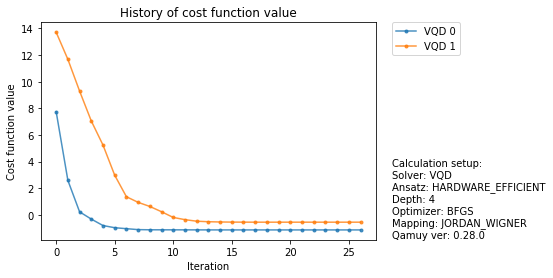

In [134]:
# Plot the cost function history (cost function = energy + penalty terms)
fig, ax = qamuy.plot.plot_cost_history(output)

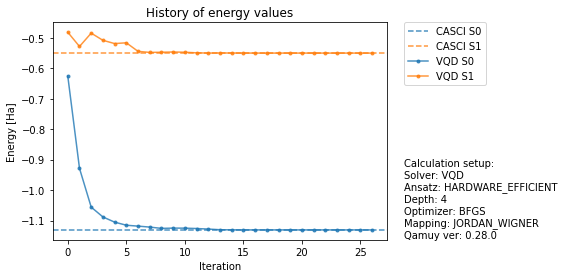

In [135]:
# Plot the energy history
fig, ax = qamuy.plot.plot_energy_history(output, state_label_map={0: "S0", 1:"S1"})

# Automatic case
I now create a function for finding the excited state energy of different configurations at the same time in order to compare the performance of various sets of parameters. Here we analyze the elapsed time and the accuracy of the calculated energy of the ground state and the excited state in order to find the best ansatz for the problem.

In [181]:
def create_benchmark_inputs(input_dictionary):
    inputs = []
    
    for solver in input_dictionary['solver']:
        for ansatz in input_dictionary['ansatz']:
            for optimizer in input_dictionary['optimizer']:
                for quantum_device in input_dictionary['quantum_device']:
                    input_qamuy = qy.QamuyChemistryInput()

                    #Solver
                    input_qamuy.solver.type = solver
                    # or "SSVQE", "MCVQE"
                    
                    if solver == 'VQD':
                        input_qamuy.cost_function.overlap_weights = [10.]

                    # Ansatz
                    input_qamuy.ansatz.type = ansatz
                    if ansatz in ['SYMMETRY_PRESERVING','HARDWARE_EFFICIENT']:
                        input_qamuy.ansatz.depth = 4
                        input_qamuy.ansatz.is_state_real = True
                    if ansatz in ['UCCD','UCCSD']:
                        input_qamuy.ansatz.spin_adapted_ref_state = True
                        input_qamuy.ansatz.trotter_steps = 1
                    if ansatz == 'FERMIONIC_ADAPTIVE':
                        input_qamuy.ansatz.adaptive_gtol = 0.0001

                    # Optimizer
                    input_qamuy.optimizer.type = optimizer
                    # or "SLSQP", "Adam", "NFT", "Powell", ...

                    # Device
                    input_qamuy.quantum_device.type = quantum_device
                    # or "SAMPLING_SIMULATOR"

                    # Cost Function
                    input_qamuy.cost_function.type="SIMPLE"

                    # add penalties
                    input_qamuy.cost_function.s2_number_weight=10.
                    input_qamuy.cost_function.sz_number_weight=10.
                    input_qamuy.cost_function.particle_number_weight=10.

                    # Post-HF methods to make a comparison
                    input_qamuy.post_hf_methods.append(qy.PostHFMethod(type="CASCI"))
                    # Chemical properties
                    properties = input_qamuy.output_chemical_properties
                    properties.append(qy.output_chemical_property(target="dipole_moment", states=[0, 1]))
                    properties.append(qy.output_chemical_property(target="oscillator_strength", state_pairs=[[0, 1]]))
                    # transition_dipole_moment, gradient, hessian, non_adiabatic_coupling, ...
                    
                    molecule = input_qamuy.target_molecule
                    molecule.geometry = qy.molecule_geometry(["H", "H"], [[0.0, 0.0, -0.35], [0.0, 0.0, 0.35]])
                    molecule.basis = "6-31g"
                    molecule.multiplicity = 1
                    molecule.sz_number = 0.0
                    molecule.num_excited_states = 1  # > 0 for calculating excited states
                    molecule.cas = qy.cas(2, 2)

                    inputs.append(input_qamuy)

    return inputs

## Ansatz benchmark

In [140]:
# You can fill in your e-mail address and password.
client = Client()

In [182]:
benchmark_options = {'solver': ['VQD'], 'ansatz': ['SYMMETRY_PRESERVING','HARDWARE_EFFICIENT','UCCD','UCCSD'], 'optimizer': ['BFGS'], 'quantum_device': ['EXACT_SIMULATOR']}
inputs = create_benchmark_inputs(benchmark_options)

In [183]:
inputs

[{'solver': {'type': 'VQD'}, 'cost_function': {'type': 'SIMPLE', 's2_number_weight': 10.0, 'sz_number_weight': 10.0, 'particle_number_weight': 10.0, 'overlap_weights': [10.0]}, 'ansatz': {'type': 'SYMMETRY_PRESERVING', 'is_state_real': True, 'depth': 4, 'reference_state': 'UNKNOWN', 'randomness_type': 'NONE', 'entanglement_pattern': 'LINEAR', 'spin_state_list': []}, 'optimizer': {'type': 'BFGS', 'differential_type': 'UNKNOWN'}, 'target_molecule': {'geometry': {'atoms': ['H', 'H'], 'coordinates': [[0.0, 0.0, -0.35], [0.0, 0.0, 0.35]], 'geometry_format': 'CARTESIAN'}, 'basis': '6-31g', 'cas': {'active_ele': 2, 'active_orb': 2, 'cas_list': []}, 'multiplicity': 1, 'sz_number': 0.0, 'num_excited_states': 1, 'molecular_orbital_format': 'NONE', 'fcidump': '', 'cart_basis': False, 'ecp': []}, 'output_chemical_properties': [{'dipole_moment': {'parameters': [{'state': 0}, {'state': 1}]}}, {'oscillator_strength': {'parameters': [{'state_pair': [0, 1]}]}}], 'quantum_device': {'type': 'EXACT_SIMULA

In [184]:
jobs = [client.submit(input) for input in inputs]
results = [client.wait_and_get_job_results([job]) for job in jobs]
# Display an error if there is a calculation that has ended in error
for i, result in enumerate(results):
    if result[0].status == qamuy.client.ResultStatus.FAILURE:
        print(f"Job {i} has failed: {result.error}")
# Extract output data from Result data
outputs = [result[0].output for result in results]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.3s finished


In [185]:
elapsed_times = [output.molecule_result.hf_result.elapsed_time for output in outputs]
elapsed_times

[0.13899155899980542,
 0.14358172899846977,
 0.14573044899952947,
 0.14609135200043966]

In [241]:
energies_s0 = []
energies_s1 = []

# chemical properties
for i, output in enumerate(outputs):
    print(f'Results for output {i}')
    q_result = output.molecule_result.quantum_device_result
    energy_s0 = qy.get_evaluated_property_for_state(q_result, "energy", state=0).value
    energy_s1 = qy.get_evaluated_property_for_state(q_result, "energy", state=1).value
    print(f'S0 energy: {energy_s0}')
    print(f'S1 energy: {energy_s1}')
    print(f'S0 dipole moment: {qy.get_evaluated_property_for_state(q_result, "dipole_moment", state=0).value}')
    print(f'S1 dipole moment: {qy.get_evaluated_property_for_state(q_result, "dipole_moment", state=1).value}')
    print(f'oscillator_strength: {qy.get_evaluated_property_for_state_pair(q_result, "oscillator_strength", state_pair=(0, 1)).value}')
    
    energies_s0.append(energy_s0)
    energies_s1.append(energy_s1)

Results for output 0
S0 energy: -1.1309255432802547
S1 energy: -0.5497906158848684
S0 dipole moment: [0.0, 0.0, 2.5677824380473507e-07]
S1 dipole moment: [0.0, 0.0, -1.069182003122018e-06]
oscillator_strength: 0.6563808522863724
Results for output 1
S0 energy: -1.1309255432795948
S1 energy: -0.5497906158849086
S0 dipole moment: [0.0, 0.0, -4.273738475196381e-16]
S1 dipole moment: [0.0, 0.0, -6.835586388522567e-16]
oscillator_strength: 0.6563818634937771
Results for output 2
S0 energy: -1.1309255432802572
S1 energy: -0.5497906158849087
S0 dipole moment: [0.0, 0.0, 0.0]
S1 dipole moment: [0.0, 0.0, 0.0]
oscillator_strength: 0.6563806448614922
Results for output 3
S0 energy: -1.1309255432802199
S1 energy: -0.5497906158849111
S0 dipole moment: [0.0, 0.0, -3.0555482953562925e-07]
S1 dipole moment: [0.0, 0.0, -1.5033102837896177e-16]
oscillator_strength: 0.6563805004112561


Results for output 0


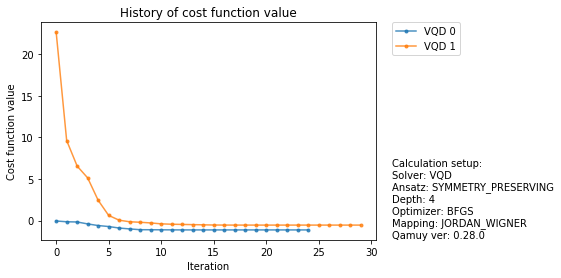

Results for output 1


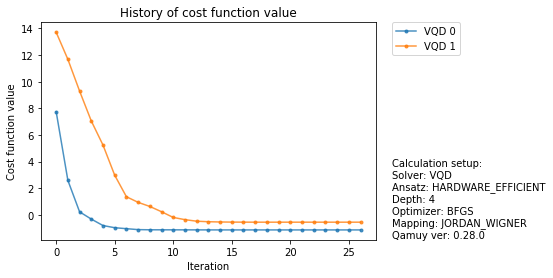

Results for output 2


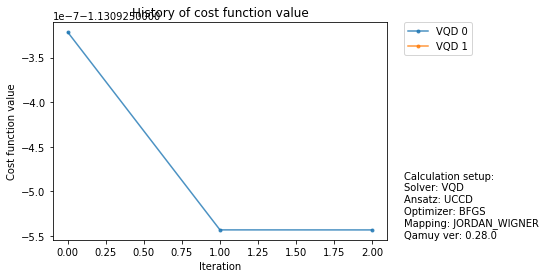

Results for output 3


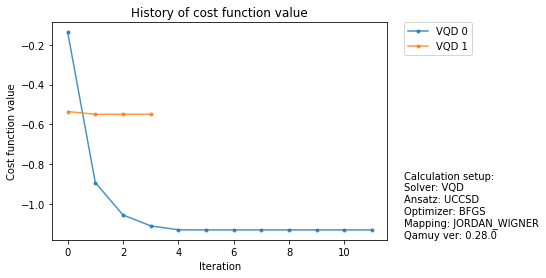

In [191]:
# Plot the cost function history (cost function = energy + penalty terms)
for i, output in enumerate(outputs):
    print(f'Results for output {i}')
    qamuy.plot.plot_cost_history(output)
    plt.show()

Results for output 0


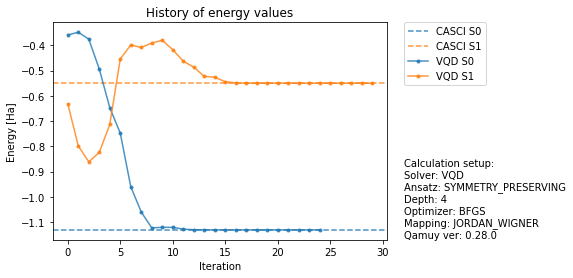

Results for output 1


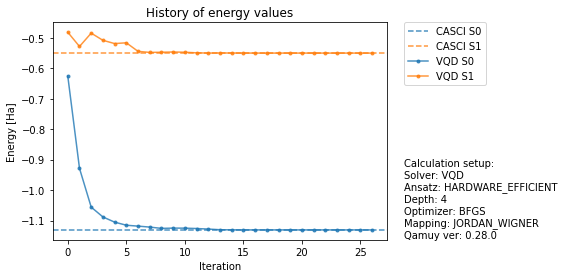

Results for output 2


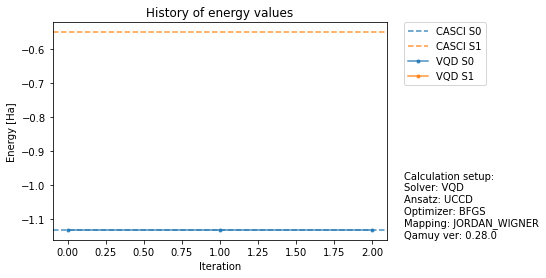

Results for output 3


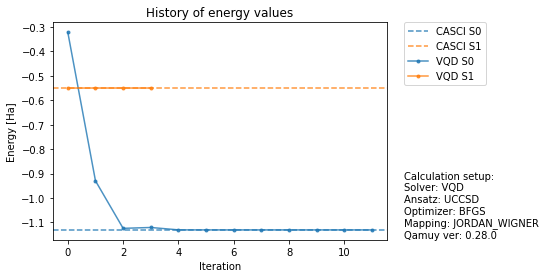

In [192]:
# Plot the energy history
for i, output in enumerate(outputs):
    print(f'Results for output {i}')
    qamuy.plot.plot_energy_history(output, state_label_map={0: "S0", 1:"S1"})
    plt.show()

In [275]:
classical_energies_s0 = [output.molecule_result.post_hf_results[0].evaluated_properties[0].energy.values[0].value for output in outputs]
classical_energies_s1 = [output.molecule_result.post_hf_results[0].evaluated_properties[0].energy.values[1].value for output in outputs]
classical_times = [output.molecule_result.post_hf_results[0].evaluated_properties[0].energy.metadata.elapsed_time for output in outputs]
classical_energies_s0, classical_energies_s1, classical_times

([-1.1309255432802652,
  -1.1309255432802643,
  -1.1309255432802638,
  -1.1309255432802652],
 [-0.5497906158849094,
  -0.549790615884909,
  -0.5497906158849085,
  -0.5497906158849085],
 [4.270200042810757e-05,
  5.400000009103678e-05,
  6.880100045236759e-05,
  6.91010009177262e-05])

In [293]:
names = [str(inputs[i].ansatz.type) for i, _ in enumerate(elapsed_times)]
names.insert(0,'CASCI')
names

['CASCI', 'SYMMETRY_PRESERVING', 'HARDWARE_EFFICIENT', 'UCCD', 'UCCSD']

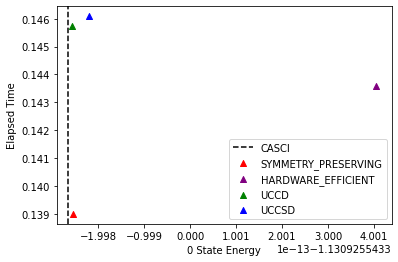

In [294]:
colors = ['red','purple','green','blue']
for i in range(len(energies_s0)):
    plt.scatter(energies_s0[i], elapsed_times[i], c=colors[i], marker='^')
    plt.xlabel('0 State Energy')
    plt.ylabel('Elapsed Time')
plt.axvline(x=np.mean(classical_energies_s0),c='black',linestyle='--')
plt.legend(names)

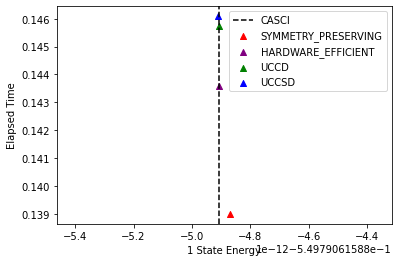

In [295]:
colors = ['red','purple','green','blue']
for i in range(len(energies_s1)):
    plt.scatter(energies_s1[i], elapsed_times[i], c=colors[i], marker='^')
    plt.xlabel('1 State Energy')
    plt.ylabel('Elapsed Time')
plt.axvline(x=np.mean(classical_energies_s1),c='black',linestyle='--',label='CASCI')
plt.legend(names)

### Partial conclusion
The results show that the *SYMMETRY_PRESERVING* ansatz performs best for finding the excited state energy of the H2 molecule as it is faster than the rest and shows an energy that is very close the the classical solution.

## Optimizer benchmark
Now I test all the optimizers that Qamuy offers while using the *SYMMETRY_PRESERVING* ansatz in order to determine the best ansatz and optimizer.

In [296]:
# You can fill in your e-mail address and password.
client = Client()

In [297]:
benchmark_options = {'solver': ['VQD'], 'ansatz': ['SYMMETRY_PRESERVING'], 'optimizer': ['BFGS','BFGS_FTOL','L_BFGS_B','NFT','NELDER_MEAD','POWELL','CG','TNC','SLSQP','ADAM'], 'quantum_device': ['EXACT_SIMULATOR']}
inputs = create_benchmark_inputs(benchmark_options)

In [298]:
inputs

[{'solver': {'type': 'VQD'}, 'cost_function': {'type': 'SIMPLE', 's2_number_weight': 10.0, 'sz_number_weight': 10.0, 'particle_number_weight': 10.0, 'overlap_weights': [10.0]}, 'ansatz': {'type': 'SYMMETRY_PRESERVING', 'is_state_real': True, 'depth': 4, 'reference_state': 'UNKNOWN', 'randomness_type': 'NONE', 'entanglement_pattern': 'LINEAR', 'spin_state_list': []}, 'optimizer': {'type': 'BFGS', 'differential_type': 'UNKNOWN'}, 'target_molecule': {'geometry': {'atoms': ['H', 'H'], 'coordinates': [[0.0, 0.0, -0.35], [0.0, 0.0, 0.35]], 'geometry_format': 'CARTESIAN'}, 'basis': '6-31g', 'cas': {'active_ele': 2, 'active_orb': 2, 'cas_list': []}, 'multiplicity': 1, 'sz_number': 0.0, 'num_excited_states': 1, 'molecular_orbital_format': 'NONE', 'fcidump': '', 'cart_basis': False, 'ecp': []}, 'output_chemical_properties': [{'dipole_moment': {'parameters': [{'state': 0}, {'state': 1}]}}, {'oscillator_strength': {'parameters': [{'state_pair': [0, 1]}]}}], 'quantum_device': {'type': 'EXACT_SIMULA

In [299]:
jobs = [client.submit(input) for input in inputs]
results = [client.wait_and_get_job_results([job]) for job in jobs]
# Display an error if there is a calculation that has ended in error
for i, result in enumerate(results):
    if result[0].status == qamuy.client.ResultStatus.FAILURE:
        print(f"Job {i} has failed: {result.error}")
# Extract output data from Result data
outputs = [result[0].output for result in results]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.9s
[

In [300]:
elapsed_times = [output.molecule_result.hf_result.elapsed_time for output in outputs]
elapsed_times

[0.13859734600009688,
 0.13525999400008004,
 0.14077974999963772,
 0.13036277100036386,
 0.15881583600094018,
 0.15068884399988747,
 0.14682190700114006,
 0.16805319800005236,
 0.15266007599893783,
 0.14178214099956676]

In [301]:
energies_s0 = []
energies_s1 = []

# chemical properties
for i, output in enumerate(outputs):
    print(f'Results for output {i}')
    q_result = output.molecule_result.quantum_device_result
    energy_s0 = qy.get_evaluated_property_for_state(q_result, "energy", state=0).value
    energy_s1 = qy.get_evaluated_property_for_state(q_result, "energy", state=1).value
    print(f'S0 energy: {energy_s0}')
    print(f'S1 energy: {energy_s1}')
    print(f'S0 dipole moment: {qy.get_evaluated_property_for_state(q_result, "dipole_moment", state=0).value}')
    print(f'S1 dipole moment: {qy.get_evaluated_property_for_state(q_result, "dipole_moment", state=1).value}')
    print(f'oscillator_strength: {qy.get_evaluated_property_for_state_pair(q_result, "oscillator_strength", state_pair=(0, 1)).value}')
    
    energies_s0.append(energy_s0)
    energies_s1.append(energy_s1)

Results for output 0
S0 energy: -1.130925543280255
S1 energy: -0.5497906158848685
S0 dipole moment: [0.0, 0.0, 2.567782438047351e-07]
S1 dipole moment: [0.0, 0.0, -1.0691820031220184e-06]
oscillator_strength: 0.6563808522863726
Results for output 1
S0 energy: -1.1309255307761577
S1 energy: -0.5497906199433924
S0 dipole moment: [0.0, 0.0, -0.0002118668783807412]
S1 dipole moment: [0.0, 0.0, 0.000140656606191979]
oscillator_strength: 0.6565061415654955
Results for output 2
S0 energy: -1.1309255429016936
S1 energy: -0.5497906155781336
S0 dipole moment: [0.0, 0.0, -6.472316692115048e-05]
S1 dipole moment: [0.0, 0.0, -3.0859142903107686e-05]
oscillator_strength: 0.6563810580997407
Results for output 3
S0 energy: -0.5869784151857589
S1 energy: -0.13030434551123835
S0 dipole moment: [0.0, 0.0, -1.5143713483377121]
S1 dipole moment: [0.0, 0.0, 0.3687331457190882]
oscillator_strength: 0.12349179827245076
Results for output 4
S0 energy: -1.130925542940136
S1 energy: -0.549790615887428
S0 dipole 

Results for output 0


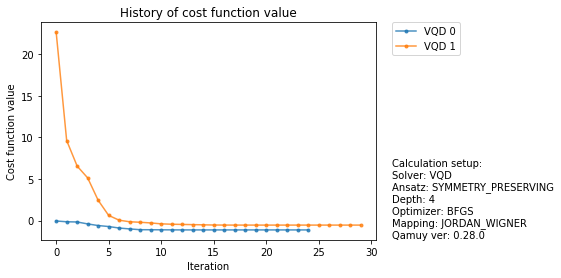

Results for output 1


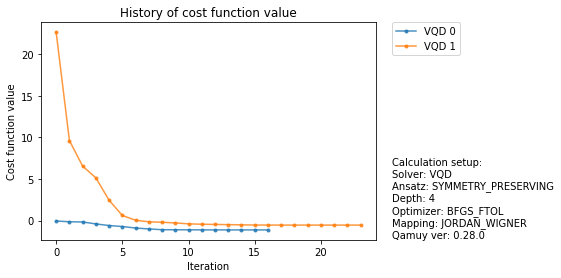

Results for output 2


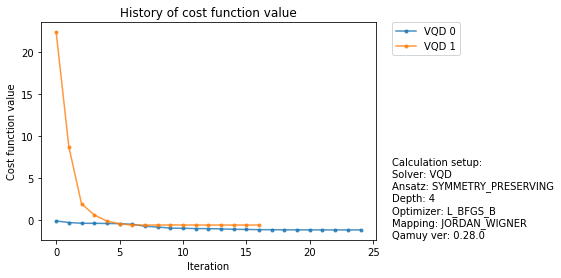

Results for output 3


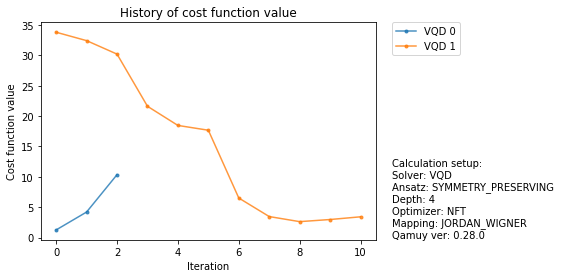

Results for output 4


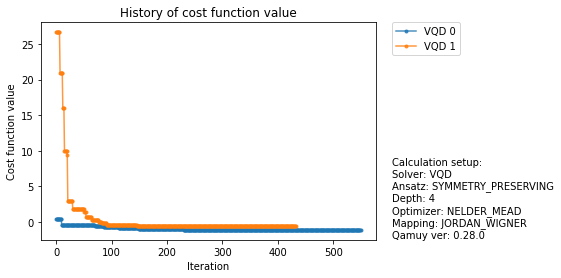

Results for output 5


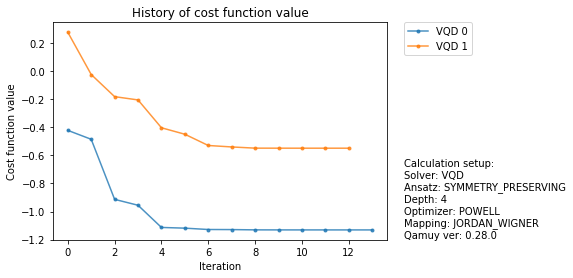

Results for output 6


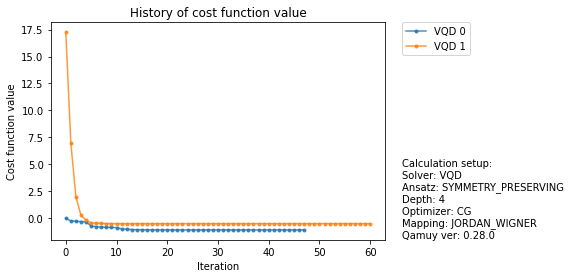

Results for output 7


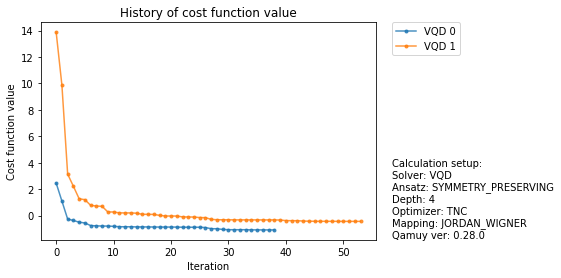

Results for output 8


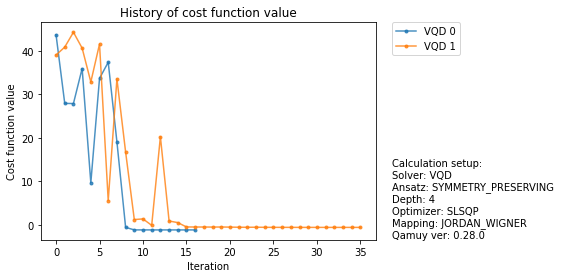

Results for output 9


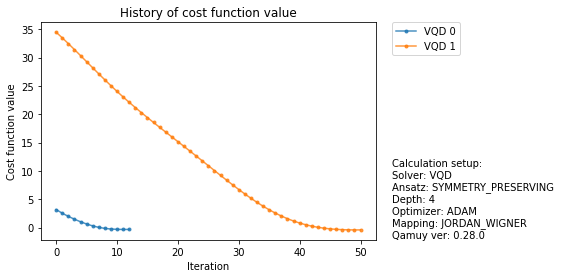

In [302]:
# Plot the cost function history (cost function = energy + penalty terms)
for i, output in enumerate(outputs):
    print(f'Results for output {i}')
    qamuy.plot.plot_cost_history(output)
    plt.show()

Results for output 0


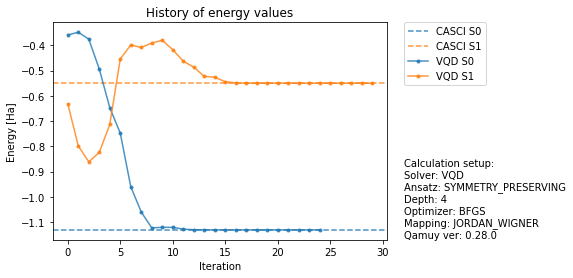

Results for output 1


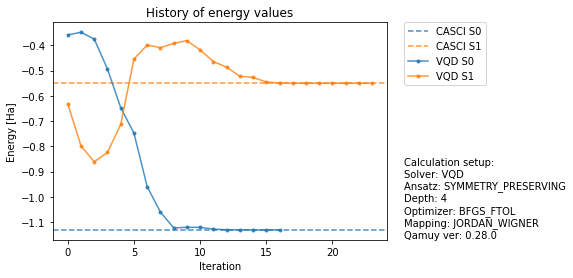

Results for output 2


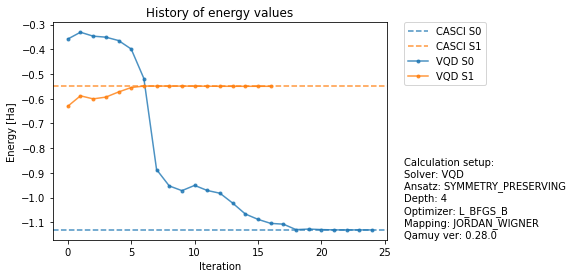

Results for output 3


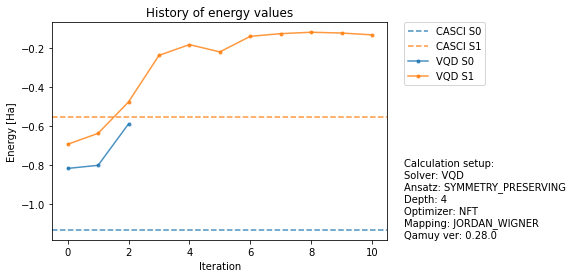

Results for output 4


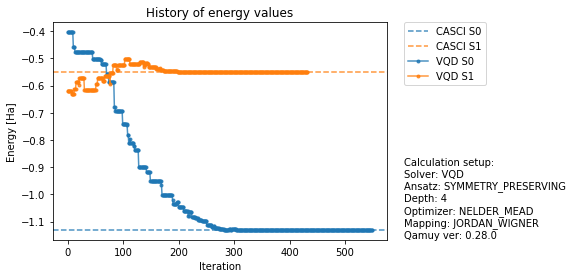

Results for output 5


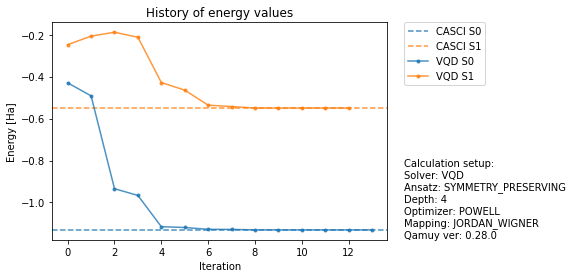

Results for output 6


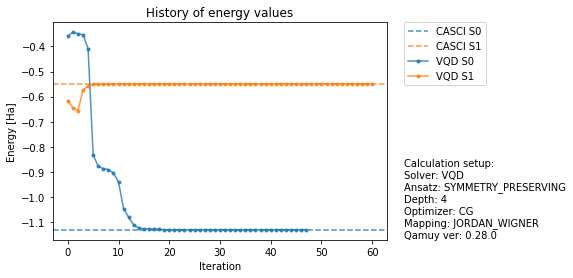

Results for output 7


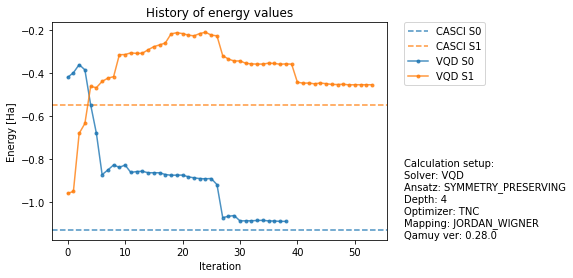

Results for output 8


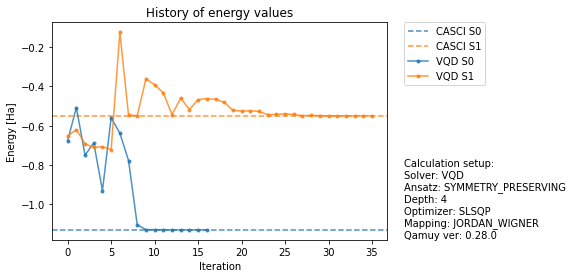

Results for output 9


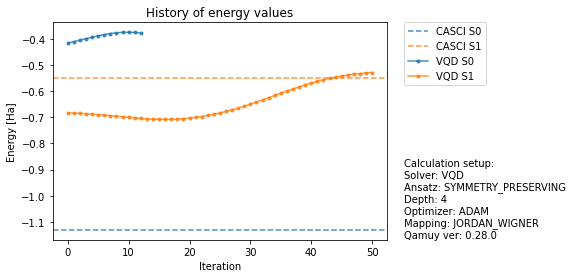

In [303]:
# Plot the energy history
for i, output in enumerate(outputs):
    print(f'Results for output {i}')
    qamuy.plot.plot_energy_history(output, state_label_map={0: "S0", 1:"S1"})
    plt.show()

In [304]:
classical_energies_s0 = [output.molecule_result.post_hf_results[0].evaluated_properties[0].energy.values[0].value for output in outputs]
classical_energies_s1 = [output.molecule_result.post_hf_results[0].evaluated_properties[0].energy.values[1].value for output in outputs]
classical_times = [output.molecule_result.post_hf_results[0].evaluated_properties[0].energy.metadata.elapsed_time for output in outputs]
classical_energies_s0, classical_energies_s1, classical_times

([-1.1309255432802652,
  -1.1309255432802643,
  -1.1309255432802638,
  -1.1309255432802643,
  -1.1309255432802652,
  -1.1309255432802652,
  -1.1309255432802652,
  -1.1309255432802647,
  -1.1309255432802647,
  -1.1309255432802652],
 [-0.5497906158849085,
  -0.549790615884909,
  -0.5497906158849076,
  -0.5497906158849085,
  -0.549790615884909,
  -0.549790615884909,
  -0.5497906158849094,
  -0.5497906158849076,
  -0.5497906158849076,
  -0.549790615884909],
 [5.020299977331888e-05,
  5.42030011274619e-05,
  6.210400169948116e-05,
  4.660199920181185e-05,
  6.000000030326191e-05,
  6.709999979648273e-05,
  5.9898999097640626e-05,
  7.869999899412505e-05,
  6.0399999711080454e-05,
  7.210000148916151e-05])

In [305]:
names = [str(inputs[i].optimizer.type) for i, _ in enumerate(elapsed_times)]
names.insert(0,'CASCI')
names

['CASCI',
 'BFGS',
 'BFGS_FTOL',
 'L_BFGS_B',
 'NFT',
 'NELDER_MEAD',
 'POWELL',
 'CG',
 'TNC',
 'SLSQP',
 'ADAM']

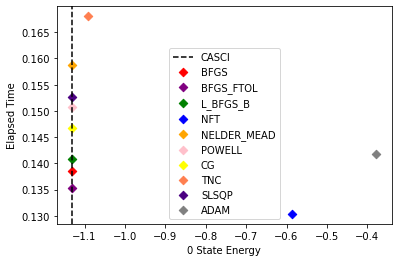

In [306]:
colors = ['red','purple','green','blue','orange','pink','yellow','coral','indigo','gray']
for i in range(len(energies_s0)):
    plt.scatter(energies_s0[i], elapsed_times[i], c=colors[i], marker='D')
    plt.xlabel('0 State Energy')
    plt.ylabel('Elapsed Time')
plt.axvline(x=np.mean(classical_energies_s0),c='black',linestyle='--')
plt.legend(names)

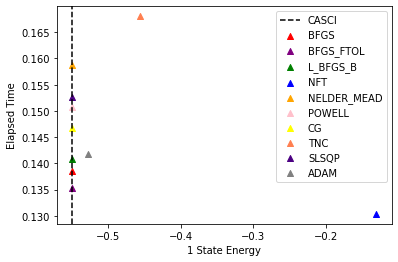

In [307]:
colors = ['red','purple','green','blue','orange','pink','yellow','coral','indigo','gray']
for i in range(len(energies_s1)):
    plt.scatter(energies_s1[i], elapsed_times[i], c=colors[i], marker='^')
    plt.xlabel('1 State Energy')
    plt.ylabel('Elapsed Time')
plt.axvline(x=np.mean(classical_energies_s1),c='black',linestyle='--',label='CASCI')
plt.legend(names)

### Conclusion
While the fastest optimizer is *NFT*, the energy it calculated was very different and incorrect, making *SLSQP* the fastest and most efficient for calculating the excited state energy while *BFGS_FTOL* is the best for finding the ground state energy. As a conclusion, the best set of parameters for the problem of finding the excited state energy of the H2 molecule is the *SYMMETRY_PRESERVING* ansatz and the *SLSQP* optimizer while using *VQD*.

# References
- Calculating transition amplitudes by variational quantum deflation (Yohei Ibe, Yuya O. Nakagawa, Nathan Earnest, Takahiro Yamamoto, Kosuke Mitarai, Qi Gao, and Takao Kobayashi)
- Variational Quantum Computation of Excited States (Oscar Higgott, Daochen Wang, and Stephen Brierley)